# Introduction

L'objectif du notebook est de concevoir un premier modèle de classification d'images. On va utiliser une architecture LeNet pour commencer. C'est un CNN simple qui va nous permettre de nous faire une première idée de la contribution des différents facteurs (données, hyper-paramètres) à la performance de notre modèle.

Nos ressources de calcul (et de temps) étant limitées, on va mener les comparaisons de la section 1 (surtout) et 2 sur un sous-ensemble des données, un nombre d'époques limité et certains hyperparamètres restreints.

On va adopter la stratégie suivante:

1. Tenter d'abord de mesurer l'impact des différentes étapes de prétraitement sur nos modèles. Toutes choses égales par ailleurs, on va tester le même modèle avec, dans l'ordre:
   1. Le dataset sans rééquilibrage de classes et avec les images non zoomées
   2. Le dataset sans rééquilibrage de classes et avec les images zoomées
   3. Le dataset avec rééquilibrage de classes et avec les images zoomées
2. Enfin, après avoir trouvé le dataset le plus approprié, on va tester l'impact de différents hyper-paramètres sur la performance:
   1. Un learning rate plus élevé avec une stratégie de _learning rate decay__
   2. Un batch_size plus gros
   3. Une taille d'image plus grande
3. On va sélectionner le dataset et les hyper-paramètres les plus prometteurs des sections précédentes et entraîner le modèle de façon plus poussée sur un dataset complet, en restaurant les hyper-paramètres qu'on avait restreints par souci d'économie de temps lors de nos comparaisons.

# Initialisation

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

[Errno 2] No such file or directory: 'drive/MyDrive/nov23_bds_rakuten'
/content/drive/MyDrive/nov23_bds_rakuten


In [ ]:
random_state = 42
output_dir = "output/data-modeling-images-1"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model

# Librairie de fonctions

Bien que je préfère en général définir les fonctions au fur et à mesure de leur utilisation, la multiplication des stratégies que nous allons tester rend plus simple de les rassembler dans cette section. En les extrayant du déroulement de chaque stratégie, nous pourrons plus efficacement dupliquer et identifier leur trame commune.

## Import des données


Commençons par définir une fonction **import_images** qui permet d'importer le jeu d'images que l'on souhaite utiliser.

In [ ]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

## Rapport de modèle

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes stratégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses résultats:
* Un nom et un id de modèle
* Les sources de données utilisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* L'état en cours de l'entraînement ainsi que le nombre d'époques à atteindre
* Les métriques de performance de l'entraînement, la validation et des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arrêtés en cas d'interruption. Dans ce cas, on veillera également à sauvegarder l'état des modèles ayant la meilleure performance, afin de compléter l'entraînement sur les époques manquantes.

Plus tard, le fichier **model_reporting.csv** nous servira aussi à comparer les modèles de chaque notebook de modélisation. Pour cette raison, on va tenter d'être le plus complet possible dans les informations qu'on y met.



Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèle d'exemple.


In [ ]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "train_size": int(42458),

      #hyper parameters
      "image_size": int(300),
      "image_color_rgb": True,
      "batch_size":int(32),
      "image_data_generator_params": {"rescale":1./255,"shear_range":0.2,"zoom_range":0.2,"horizontal_flip":True},
      "start_lr": 0.001,
      "last_lr": 0.0001,
      "optimizer": "adam",

      #fit info
      "target_epochs": int(10),
      "last_epoch": int(6),
      "fit_complete": True,

      #metrics
      "f1_score": 0.42,
      "val_f1_score": 0.37,
      "test_f1_score": 0.35,
      "accuracy": 0.57,
      "val_accuracy": 0.39,
      "test_accuracy": 0.41,
      "loss": 1.567,
      "val_loss": 2.657,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe.


In [ ]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**.

In [ ]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption.

In [ ]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle.

In [ ]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Création du modèle

Ajoutons une fonction **build_model** qui va nous permettre de créer les différentes couches de notre architecture LeNet.


In [ ]:
def build_model(input_shape):
    model = Sequential()

    model.add(Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))

    model.add(Dense(27, activation='softmax'))

    return model

Nous allons également avoir besoin d'une métrique personnalisée **w_f1_score** qui permette de calculer le F1 Score pondéré. On veille à ajouter l'annotation **@keras.saving.register_keras_serializable** pour que Keras ne pose pas de problème lors du chargement du modèle.


In [ ]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

## Sauvegarde du modèle

Toujours en vue d'être résilient par rapport aux interruptions qui ont lieu régulièrement lors de la phase d'entraînement du modèle, créons des fonctions qui vont nous permettre de sauvegarder et restaurer un modèle Keras, afin de pouvoir reprendre l'entraînement s'il a été stoppé, ou même d'afficher les métriques d'un modèle dont l'entraînement est complet.


In [ ]:
def load_saved_model(model_id):
  model_path = output_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

In [ ]:
def save_model(model_id,model):
  path = output_dir+("/model-%d.keras" % model_id)
  print("save model ",model_id,"to ",path)
  model.save(path)

Comme nous allons afficher des graphiques sur l'évolution des métriques pendant l'entrainement, il nous faut également des fonctions qui nous permettent de sauver, charger un historique

In [ ]:
def load_training_history(model_id):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  history = None
  if Path(path).exists():
    with open(path, "rb") as file:
      history = pickle.load(file)
  return history

In [ ]:
def save_training_history(model_id,history):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  with open(path, "wb") as file:
    pickle.dump(history,file)

Parcequ'un entrainemnt peut être fait en plusieurs fois, nous devons pouvoir concaténer un historique d'entrainement actuel avec le précédent sauvegardé.

In [ ]:
def concat_training_histories(prev_history,actual_history):
  full_history = {}
  for key in actual_history:
    full_history[key]=np.concatenate((prev_history[key],actual_history[key]),axis=0)
  return full_history

In [ ]:
def get_full_training_history(model_id,training_history):
  if training_history == None:
    history = load_training_history(model_id)
  else:
    prev_history = load_training_history(model_id)
    if prev_history != None:
      history = concat_training_histories(prev_history,training_history.history)
    else:
      history = training_history.history
  return history

## Callbacks pour l'entraînement du modèle

La callback **LogBest** va nous permettre de sauvegarder l'état de l'entraînement et les métriques du modèle à la fin de chaque époque.

Seules les meilleures métriques sont sauvegardées. Elles correspondent à la meilleure époque du modèle que nous sauvegardons également. Elles sont donc mises à jour au fur et à mesure de l'entraînement.


In [ ]:
class LogBest(Callback):
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):

        update_reporting_line(self.model_id,{
            'last_epoch': epoch +1, # Epochs are 0-indexed, so we add 1
            'last_lr': float(K.get_value(self.model.optimizer.learning_rate)),
        })

        if float(logs['val_w_f1_score']) <= float(get_reporting_value(self.model_id,"val_f1_score",0.0)):
          return
        print("\nFound better model with val_f1_score=%.2f" % float(logs['val_w_f1_score']))
        update_reporting_line(self.model_id,{
            "f1_score": logs['w_f1_score'],
            "val_f1_score": logs['val_w_f1_score'],
            "accuracy": logs['accuracy'],
            "val_accuracy": logs['val_accuracy'],
            "loss": logs['loss'],
            "val_loss": logs['val_loss'],
        })
        save_model(self.model_id,self.model)


Cette callback nous permet de stopper l'entraînement lorsque le F1 Score ne progresse plus.


In [ ]:
early_stopping = EarlyStopping(
              monitor='val_w_f1_score',
              mode="max", #stop when f1 score is not increasing anymore
              patience=5,           # Number of epochs with no improvement
              min_delta=1e-2,       # Minimum change to qualify as an improvement
)

## Évaluation du modèle

Ajoutons quelques fonctions qui vont nous faciliter l'affichage de graphiques et de matrices lors de la phase d'évaluation du modèle.


La fonction **plot_training_history** permet d'afficher l'évolution des différentes métriques en suivant le cours des époques de la phase d'entraînement.


In [ ]:
def plot_training_history(history):
  x = range(1,len(history['accuracy']) + 1 )
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(x,history['val_accuracy'],label="val_accuracy")
  plt.plot(x,history['accuracy'],label="accuracy")
  plt.plot(x,history['val_w_f1_score'],label="val_f1_score")
  plt.plot(x,history['w_f1_score'],label="f1_score")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title("Accuracy/f1 evolution during training")
  plt.legend()

  plt.subplot(122)
  plt.plot(x,history['val_loss'],label="val_loss")
  plt.plot(x,history['loss'],label="loss")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss evolution during training")
  plt.legend()

  plt.show()


Ici, on récupère du notebook **data-exploration** les labels correspondant aux classes, pour donner plus de lisibilité lors de l'évaluation.


In [ ]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant,déguisement",
    1281 : "Jeu société",
    1300 : "Jouet tech",
    1301 : "Jeu intérieur,chaussettes",
    1302 : "Jeu extérieur,vêtement",
    1320 : "Bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues,journaux",
    2403 : "Magazines,livres,BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique,papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

Enfin, ajoutons une fonction **plot_confusion_matrix** qui nous permette d'afficher la matrice de confusion de manière lisible.


In [ ]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  classes = [(str(c) +": "+ prdcodetype2label[int(c)]) for c in classes_keras]
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g'
              ,xticklabels=classes,yticklabels=classes)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

# Modélisation 1.1

Pour cette première modélisation, on va appliquer la stratégie 1.1. C'est-à-dire tester un modèle simple LeNet sur les données sans rééquilibrage et sans zoom sur les images.


Commençons par initialiser la variable **model_id**. Pour les IDs de modèles, on va adopter une convention à trois chiffres:

1. Le numéro du notebook (ici 1)
2. Le premier niveau de stratégie (ici 1)
3. Le deuxième niveau de stratégie (ici 1 également)


In [ ]:
model_id = 111

## Import des données

On va donc importer les images dans leur version originale (non zoomées).


In [ ]:
image_path = import_images("data/images.zip","/tmp/rakuten-images-1")

images already imported from drive


Chargeons maintenant les données du dataset sans rééchantillonnage.

In [ ]:
df = pd.read_csv("output/data-exploration/X_train_pre.csv")
df.head()

,index,productid,imageid,prdtypecode,text,lang
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr


## Preprocessing

Cette version du dataset ne contenant pas encore la colonne **imagefile** qui va nous être nécessaire, ajoutons-la.


In [ ]:
df["imagefile"] = "image_" + df["imageid"].astype("str") + "_product_" + df["productid"].astype("str") + ".jpg"
df.head()

,index,productid,imageid,prdtypecode,text,lang,imagefile
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,image_1263597046_product_3804725264.jpg
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,image_1008141237_product_436067568.jpg
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,image_938777978_product_201115110.jpg
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,image_457047496_product_50418756.jpg
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,image_1077757786_product_278535884.jpg


On souhaite mener nos tests avec un ensemble d'entraînement constitué d'environ 25% des données, soit environ 42,000 observations. On tentera de conserver le même nombre d'observations pour les ensembles d'entraînement qu'on va utiliser aux différentes étapes de notre stratégie.

On va d'abord constituer un ensemble de test et un ensemble de validation identiques à ceux générés par le notebook **data_preprocessing_resampling**. Cela nous facilitera les comparaisons dans le cadre de notre stratégie.


Créons deux variables **X** et **y** qui vont contenir respectivement les variables explicatives et la variable cible.


In [ ]:
X = df.drop("prdtypecode",axis=1)
y = df["prdtypecode"]

Commençons par scinder les données en un ensemble d'entraînement (**X_train**, **y_train**) et un ensemble de test (**X_test**, **y_test**).

Ce premier ensemble de test comprend 20% des données choisies aléatoirement mais en respectant la répartition initiale des classes. On veille également à toujours passer le même **random_state** pour s'assurer que la fonction renvoie toujours le même résultat si on doit ré-exécuter ce notebook plus tard.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state,shuffle=True,stratify=y)

On va maintenant couper en deux l'ensemble de test pour que la moitié de ses données aillent dans un ensemble de validation (**X_val**, **y_val**).


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state = random_state,shuffle=True,stratify=y_test)

Finalement, on réduit encore l'ensemble d'entrainement pour qu'il contienne environ 25% des données de départ.

In [ ]:
target_train_size = int(len(X) * 0.25)
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 21229
X_train length is now 21229


## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.


In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
#test todo: remove
#reporting_df = create_reporting_df()

In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.


In [ ]:
add_reporting_line(model_id,"Modèle 1.1.1")

On peut déjà renseigner les informations sur les données sources qu'on utilise.


In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-exploration/X_train_pre.csv",
    "dataset_resampled": False,
    "image_dataset_source" : "data/images.zip",
    "image_dataset_zoomed" : False,
    "train_size": len(X_train),
})

## Générateurs d'images

Dans cette section, nous allons créer les générateurs qui vont fournir au modèle les images.


Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


Pour le générateur d'entraînement, on va volontairement limiter les transformations appliquées aux images afin de réduire le temps d'entraînement. Rappelons que nous ne sommes pas pour l'instant à la recherche de la meilleure performance. On souhaite juste avoir une base de comparaison solide pour nos différentes stratégies. On les laisse toutefois suffisamment élevées pour bénéficier d'une bonne généralisation du modèle malgré un **batch_size** de 64, ce dernier étant relativement élevé comparé à la taille des images et au choix de l'architecture.

Pour la même raison et aussi car on utilise une architecture simple comme LeNet, on restreint également la taille des images à 128x128.


In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})
batch_size=64
target_img_size = (128,128,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)





Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée. On choisit d'utiliser le taux d'apprentissage par défaut (0.001) pour comparer nos stratégies, toujours dans l'esprit de garder une base de comparaison simple.


In [ ]:
model = load_saved_model(model_id)
start_lr = 0.001
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-111.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                 

## Entraînement du modèle

On procède à l'entraînement du modèle uniquement si le rapport nous indique que son entraînement n'est pas fini (colonne **fit_complete**).

Dans le cas de la reprise d'un entraînement interrompu, on reprend l'entraînement pour le nombre d'époques qu'il reste à accomplir pour atteindre le nombre d'époques visé (**target_epochs**).

Une fois l'entraînement terminé, on passe **fit_complete** à **True**.

Les métriques sur la progression de l'entraînement ainsi que les meilleurs modèles sont récoltées et enregistrées dans la callback **LogBest**.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Évaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, on recharge le meilleur modèle qu'on a trouvé.


In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test.

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 42s 314ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fournit à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.


In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2376
accuracy on test dataset=0.2904


On observe un F1 Score de *0.24* plutôt bas, mais ce n'est pas étonnant si on se rappelle qu'on entraîne le modèle sur seulement 25% des données et que le ratio entre la taille du jeu de test et celle du jeu d'entraînement est inférieur à 1/3, alors que les usages communs le situent normalement autour de 10%.

Rappelons que le but de ce test n'est pas d'obtenir une performance élevée, mais plutôt de pouvoir comparer différents jeux de données.


Récupérons l'historique d'entraînement complet grâce à **get_full_training_history** qu'on va enregistrer. Puis, affichons deux graphiques :

* L'évolution de l'accuracy et du score F1 en fonction des époques.
* L'évolution des indicateurs de perte **loss** et **val_loss**.


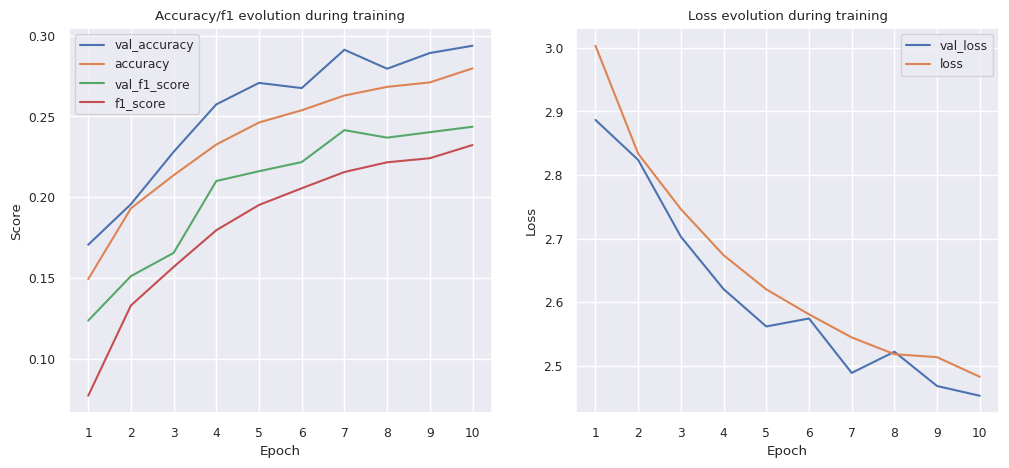

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

Le graphique de droite nous indique que la **loss** semble bien converger vers un minimum qui n'est pas atteint avec ce nombre restreint d'époques. On observe tout de même un ralentissement léger et progressif dont il faudra peut-être s'occuper en ajustant le taux d'apprentissage pendant l'entraînement. **val_loss** et **loss** sont au coude à coude, **val_loss** étant même légèrement inférieure. C'est un bon signe car cela traduit qu'il n'y a pas d'overfitting.

La tendance laisse à penser que le modèle pourrait encore gagner en performance s'il était entraîné plus longuement.

Sur le graphe de gauche, on observe logiquement la tendance inverse pour **accuracy** et **f1_score**. Les graphes sont quasi symétriques, une augmentation qui a tendance à ralentir à partir du milieu de la phase d'entraînement.

On observe une bonne généralisation de l'apprentissage puisque les indicateurs de validations sont supérieurs à ceux d'entraînement.

Cela confirme qu'il reste un bon potentiel d'amélioration sur des entraînements plus poussés.


On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.


In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.29      0.35      0.32       311
        1140       0.08      0.04      0.05       267
        1160       0.38      0.68      0.48       396
        1180       0.00      0.00      0.00        76
        1280       0.14      0.24      0.18       487
        1281       0.17      0.05      0.08       207
        1300       0.26      0.36      0.30       505
        1301       0.00      0.00      0.00        81
        1302       0.22      0.03      0.06       249
        1320       0.00      0.00      0.00       324
        1560       0.24      0.20      0.22       507
        1920       0.49      0.44      0.46       431
        1940       0.00      0.00      0.00        81
        2060       0.33      0.22      0.27       499
        2220       0.00      0.00      0.00        82
        2280       0.36      0.37      0.37       476
        2403       0.35      0.41      0.38       477
        2462       0.26    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On observe que plusieurs classes n'ont aucunes prédictions correctes, comme le révèle leur F1-score à zéro. Si on regarde la colonne **support**, on remarque que cela concerne en priorité les classes ayant le plus faible nombre d'occurrences (autour de 80).

En fait, on peut même affirmer que la totalité des classes les moins peuplées, hormis la **2905**, ont un score de 0 ou proche.

Le jeu d'entraînement reflétant les proportions de classes qu'on observe dans le jeu de test, il semble plutôt logique que les classes les moins entraînées aient le score le plus bas.

Il sera intéressant de voir si l'utilisation du jeu de données ré-équilibré corrige ce problème.


Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

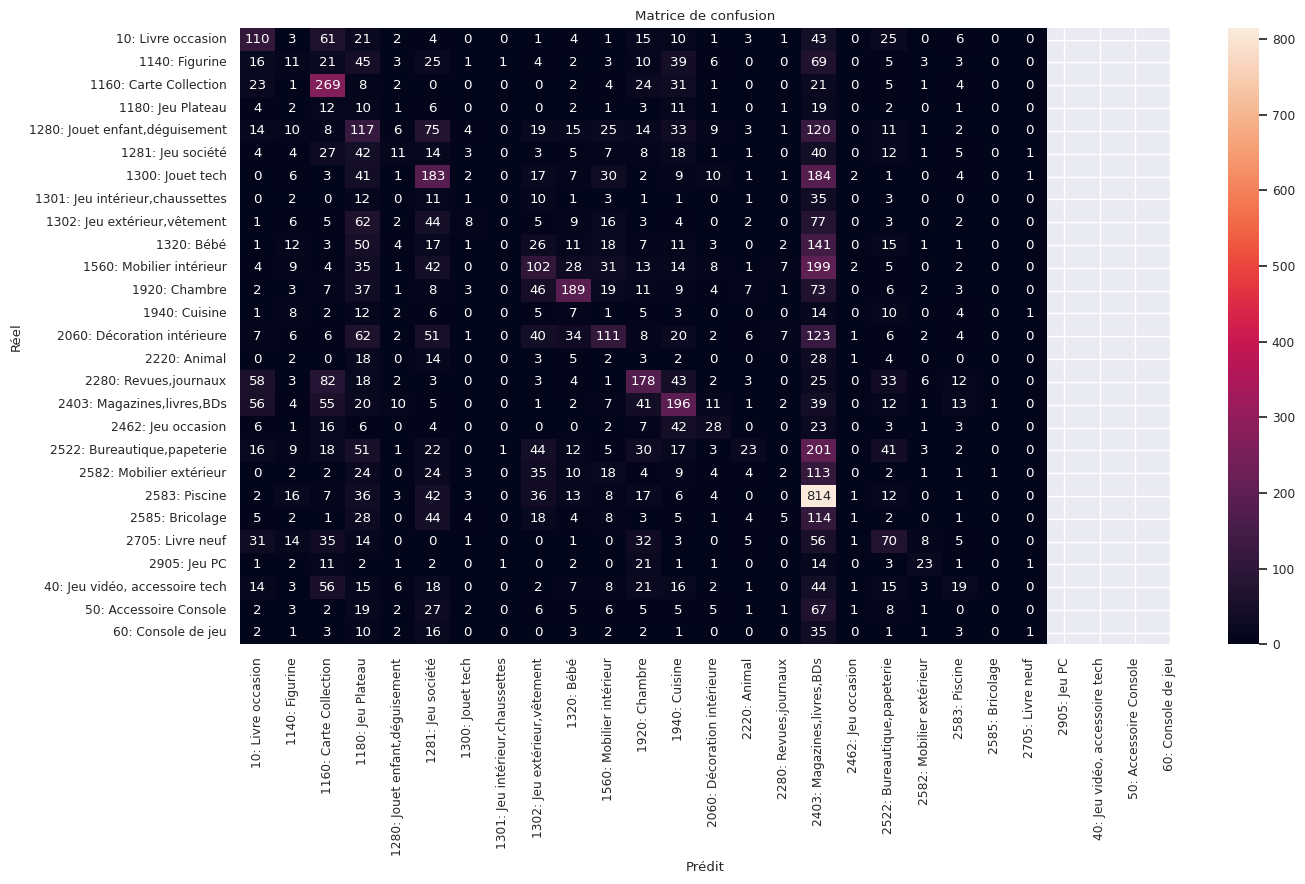

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



Un rapide aperçu nous montre que les performances ne sont pour l'instant pas bonnes. La matrice est presque noire et les niveaux plus élevés de prédictions ne se situent pas sur la diagonale des vrais positifs qui elle est difficile à discerner.

La classe **2403** _"Magazines, livres et BDs"_ génère un grand nombre de faux positifs. Elle est particulièrement confondue avec la classe **2583** _"Piscine"_. Les autres faux positifs ne sont pas plus faciles à comprendre.

On remarque aussi une diagonale de confusions élevées assez proche de la diagonale des vrais positifs.

Ne nous attardons pas trop sur ces confusions qui peuvent sans doute s'expliquer par les données d'entraînement limitées.

Enfin, notons tout de même l'absence de prédictions du modèle sur les classes les plus à droite.


## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle.

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.1
dataset_source                           output/data-exploration/X_train_pre.csv
dataset_resampled                                                          False
image_dataset_source                                             data/images.zip
image_dataset_zoomed                                                       False
train_size                                                               21229.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.2

On va maintenant tester les paramètres du même modèles mais en utilisant cette fois les images zoomées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 112

## Import des données

Cette fois-ci, on importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données modifié par le même notebook. La seule différence par rapport au dataset de la modélisation 1.1, étant l'ajout d'une colonne **imagefile** contenant les chemins relatifs de fichiers.  

In [ ]:
df = pd.read_csv("output/data-preprocessing-images/df_pre.csv")
df.head()

,index,productid,imageid,prdtypecode,text,lang,text_fr,imagefile
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...,10/image_1263597046_product_3804725264.jpg
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,2280/image_1008141237_product_436067568.jpg
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,50/image_938777978_product_201115110.jpg
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,Peluche Donald - Europe - Disneyland 2000 (Mar...,1280/image_457047496_product_50418756.jpg
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,La Guerre Des Tuques - Luc a des idées de gran...,2705/image_1077757786_product_278535884.jpg


## Preprocessing

On doit refaire la préparation des ensembles de données d'entrainement, de validation et de test, ayant changé de dataset source.

Malrgé le changement de source de données, la préparation reste identique

Créons deux variables **X** et **y** qui vont contenir respectivement, les variables explicatives et la variable cible.

In [ ]:
X = df.drop("prdtypecode",axis=1)
y = df["prdtypecode"]

Commençons par scinder les données en un set d’entraînement (**X_train**,**y_train**) et un set de test (**X_test**,**y_test**).

Ce premier ensemble de test comprend 20% des données choisies aléatoirement mais en respectant la répartition initiale des classes. On veille également à toujours passer le même **random_state** pour s'assurer que la fonction renvoie toujours le même résultat si on doit ré-executer ce notebook plus tard.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state,shuffle=True,stratify=y)

On va maintenant couper en deux l'ensemble de test pour que la moitié de ses données aillent dans un ensemble de validation (**X_val**,**y_val**).

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state = random_state,shuffle=True,stratify=y_test)

Finalement, on réduit encore l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ.

In [ ]:
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 21229
X_train length is now 21229


## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-images/df_pre.zip",
    "dataset_resampled": False,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il ny a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-112.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                   

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 27s 206ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2428
accuracy on test dataset=0.2953


On observe des scores légerement plus élevés que lors de la modélisation 1.1.

On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

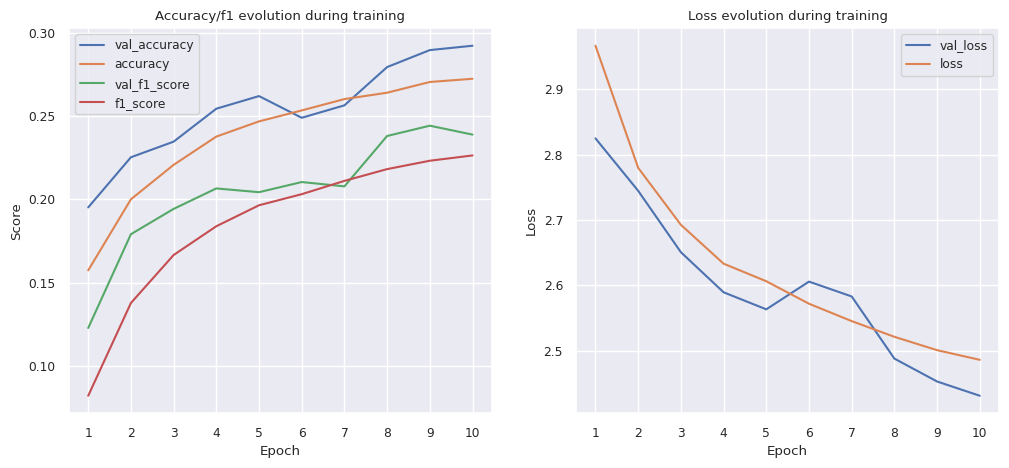

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

Les tendances des courbes sont similaires à celles des la modèlisation 1.1 malrgé un léger creux vers l'époque 7 pendant lequel les indicateurs de validation passent temporairement en dessous de ceux d'entrainement

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.31      0.27      0.29       311
        1140       0.16      0.17      0.17       267
        1160       0.38      0.76      0.50       396
        1180       0.00      0.00      0.00        76
        1280       0.18      0.13      0.15       487
        1281       0.08      0.02      0.03       207
        1300       0.25      0.35      0.29       505
        1301       0.00      0.00      0.00        81
        1302       0.14      0.04      0.06       249
        1320       0.26      0.02      0.05       324
        1560       0.22      0.21      0.22       507
        1920       0.38      0.61      0.47       431
        1940       0.00      0.00      0.00        81
        2060       0.29      0.26      0.28       499
        2220       0.00      0.00      0.00        82
        2280       0.28      0.46      0.35       476
        2403       0.30      0.40      0.35       477
        2462       0.40    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pas de changement notables ici par rapport à la modélisation précédente.

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

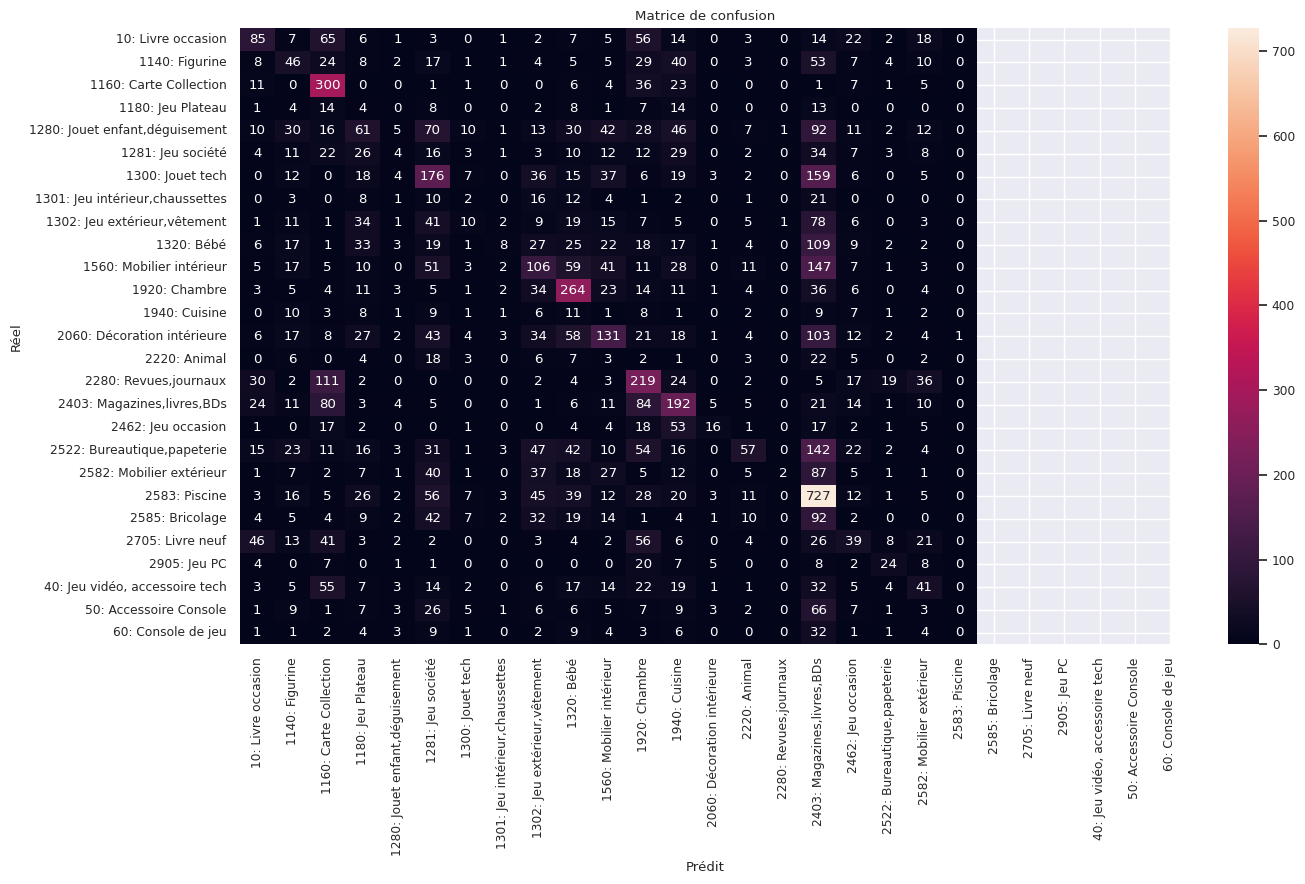

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



Bien que la matrice de confusion soit proche de celle de la modèlisation 1.1, on note tout de même une repartion plus dispersée du nombre d'erreurs de prédictions. La catégorie **2403** voit son nombre de faux positifs baisser, ce qui n'est pas le cas pour la diagonale d'erreurs de predictions qu'on avait remarqué auparavant.

Il est encore difficile de tirer des conclsions mais on pourrait penser que les images zoomées permettent au modèle de mieux extraire les informations.

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.2
dataset_source                       output/data-preprocessing-images/df_pre.zip
dataset_resampled                                                          False
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21229.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.3

On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 113

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv")
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_train.head()

,Unnamed: 0,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10
2,2,651353882,1033554185,Lecons De Sciences - Cours Superieur - Premier...,fr,Lecons De Sciences - Cours Superieur - Premier...,10/image_1033554185_product_651353882.jpg,10
3,3,4043473264,1306457352,Generations Of Women Historians -,en,Générations de femmes historiens -,10/image_1306457352_product_4043473264.jpg,10
4,4,679913105,1034656535,Oeuvres Dramatiques De F. Schiller Tome 6 -,fr,Oeuvres Dramatiques De F. Schiller Tome 6 -,10/image_1034656535_product_679913105.jpg,10


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 21229
X_train length is now 21229


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1560    787
1300    787
1281    787
2060    787
10      787
2522    787
1302    787
2583    786
1301    786
1940    786
2705    786
40      786
2582    786
60      786
2280    786
1320    786
2220    786
1920    786
2905    786
1280    786
1180    786
2403    786
2585    786
2462    786
1140    786
1160    786
50      786
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.3")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-113.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 27s 199ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2071
accuracy on test dataset=0.2083


On constate une baisse des score par rapport aux deux jeux de données précédents

On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

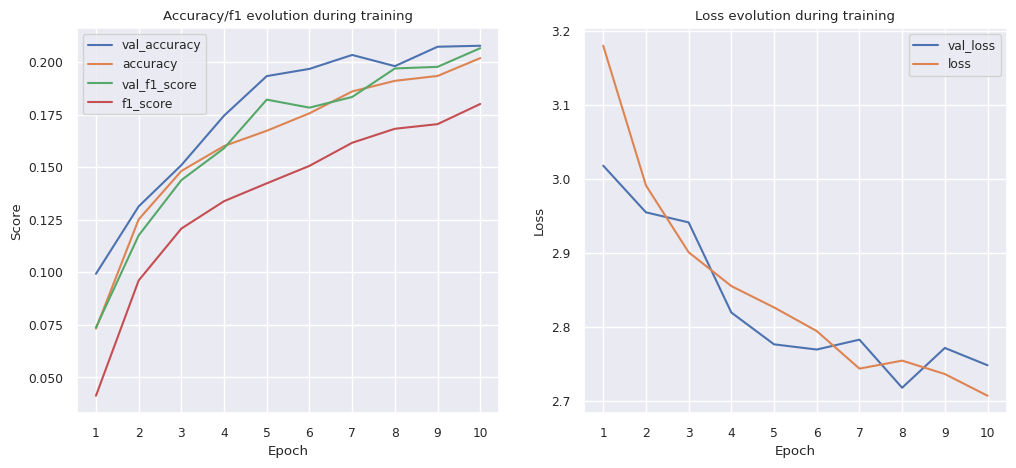

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

Même si les courbes ont des tendances similaires aux modèles précédents, on remarque qu'elles sont moins lisse. En particulier la courbe **val_loss** qui fluctue plus.

On remarque un claire ralentissement de la diminution de **loss** à partir de l'éopque 3 puisqu'on passe de 0.1 point par époque à 0.1 pour 3 époques. Ce ralentissement s'accentue encore à l'éopque 7 ou il semble doubler pour passer à 0.1 pour 6 époques.

Ca laisse penser qu'implémenter une stratégie de variation progressive du learning rate pourrait être bénéficiable. On verra ça dans la modélisation 2.1.

Coté **accuracy** et **f1_score** les courbes de validations sont toujours au dessus. On aurait pu craindre l'overfitting avec l'utilsation de donnée ré-échantilloné avec des doublons mais ce n'est pas le cas. Il est probable que les transformations appliquées aux images par les **ImageDataGenerator** empechent ça.

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.24      0.29      0.26       311
        1140       0.13      0.16      0.14       267
        1160       0.50      0.57      0.53       396
        1180       0.00      0.00      0.00        76
        1280       0.04      0.00      0.00       487
        1281       0.09      0.07      0.08       207
        1300       0.26      0.20      0.22       505
        1301       0.05      0.10      0.06        81
        1302       0.10      0.04      0.06       249
        1320       0.16      0.15      0.16       324
        1560       0.21      0.17      0.19       507
        1920       0.42      0.46      0.44       431
        1940       0.04      0.31      0.08        81
        2060       0.27      0.25      0.26       499
        2220       0.01      0.01      0.01        82
        2280       0.53      0.17      0.26       476
        2403       0.30      0.27      0.29       477
        2462       0.12    

On note cette fois ci une diminution du nombre de classes ayant des scores à zéros. Seules 3 classes sont à zéro contre 6-7 dans les modélisations précédentes. C'est certaienemnt gràce au ré-équilibrage.

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

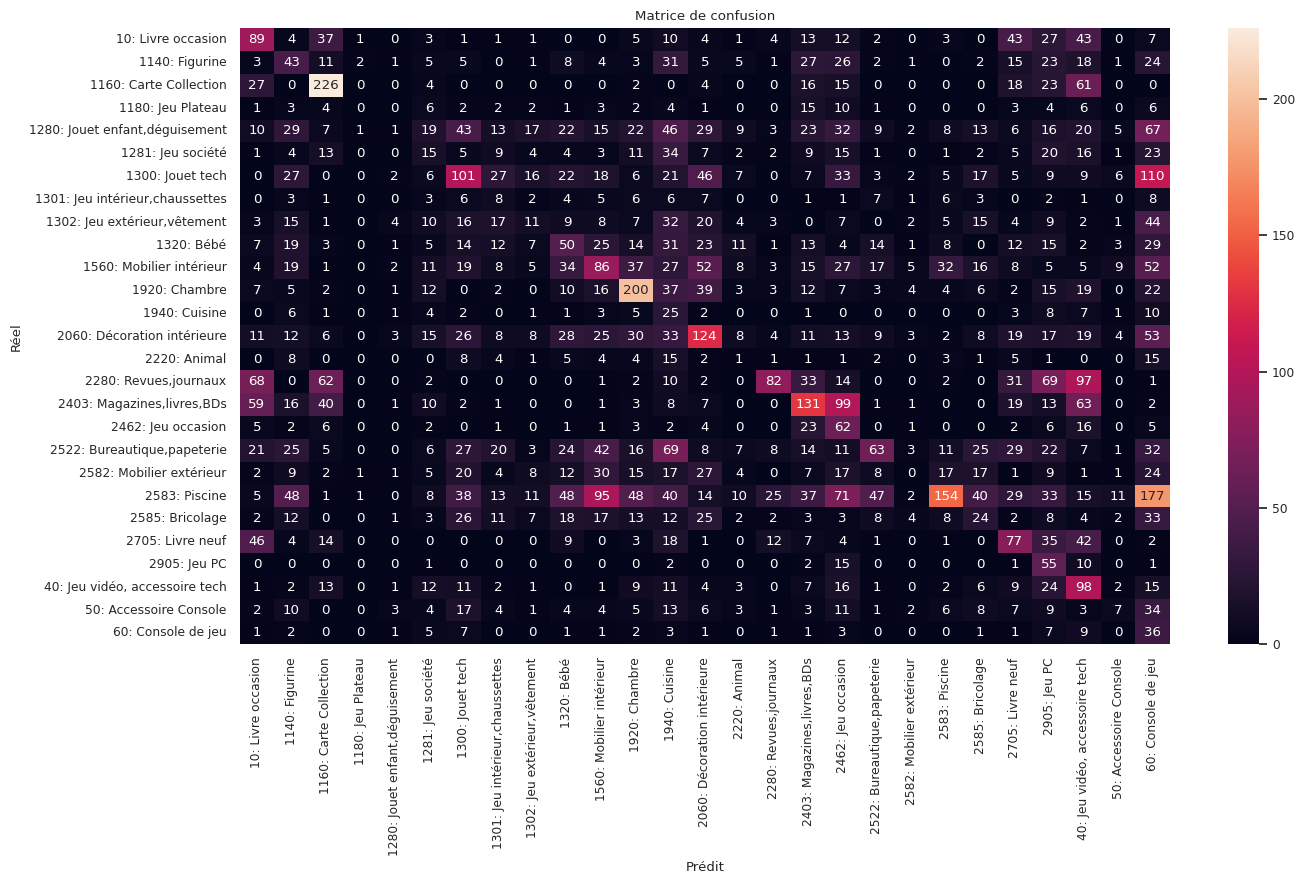

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



On remarque tout d'abord que cette fois, le modèle à réussis à fournir des prédictions sur les classes de droite qui manquaient jusqu'à maintenant.

On note également l'apparition d'une diagonale de vrais positifs bien qu'encore un peu noyée dans le bruit avoisinnant.

La classe **2403** voit son nombre de faux positifs diminuer

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.3
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21229.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Comparaison des modélisations de la stratégie 1

On va maintenant pouvoir comparer les rapports des 3 modélisations. Affichons leur rapport côte à côte en ôtons les informations non pertinentes pour plus de clarté.

In [ ]:
model_comparison_cols = ["model_name","dataset_resampled","image_dataset_zoomed",
        "train_size","image_size","batch_size","test_f1_score","test_accuracy",
          "loss","val_loss"]
display(reporting_df.loc[[111,112,113],model_comparison_cols].T)

model_id,111,112,113
model_name,Modèle 1.1.1,Modèle 1.1.2,Modèle 1.1.3
dataset_resampled,False,False,True
image_dataset_zoomed,False,True,True
train_size,21229.0,21229.0,21229.0
image_size,128.0,128.0,128.0
batch_size,64.0,64.0,64.0
test_f1_score,0.23761,0.242837,0.207138
test_accuracy,0.290391,0.295337,0.208314
loss,2.482575,2.500585,2.707499
val_loss,2.452756,2.452618,2.748649


Nos tests laissent à penser que l'utilsation d'image zoomées semblent judicieux.

Le choix du datset ré-équilibré est plus difficile. D'un coté le f1-score penche en faveur du non mais une observation plus détaillée des rapports de classification et matrices de confusion indique qu'il semble plus prometteur. Ne pas l'utiliser impliquerait aussi de rennoncer à avoir des prédictions pour certaines classes ce qui compromettrait la fiabilité de nos futurs tests.

Nous décidons donc de d'utiliser un dataset avec images zoomées + ré-équilibrage pour la suite.


# Modélisation 2.1

Maintenant que nous avons identifié le modéles le plus prometteur de la section, nous allons pouvoir tester l'impact de quelques hyper-paramètres sur ses performances.

Commençons par le learning rate. Pour tenter d'accélerer l'apprentissage, nous allons tenter d'augmenter le learning rate de départ. Ensuite nous allons adopter une stratégie de reduction graduelle du learning rate plus communement appelée _Learning rate decay_

Tous les autres paramètres ainsi que le jeu de données seront mantenant constants afin de tenter d'isoler l'impact

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 121

## Import des données

Comme nous ré-utilisons simplement le jeu de données de la modélisaton 1.3, pas besoin de ré-importer les données

## Preprocessing

On va également ré-utiliser les même jeux d'entrainement, de validation et de test

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.2.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-121.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                   

## Entrainement du model

Crééons une callback qui va nous permettre d'impléementer notre stratégie de _Learning rate decay_. Si on revient sur les graphs de **loss** de la modélisation 1.3, on observe que le ralentissment la diminution de **loss** intervient dés l'époque 3. On choisi donc un **decay_step** relativement bas pour s'assurer un ajustement qui commence rapidement.

On laisse le **start_lr** inchangé car un test __off screen__ d'un **start_lr** multplié par 10 revèle que ça ne marche pas bien

In [ ]:
def learning_rate_decay(epoch, lr):
    initial_lr = start_lr
    decay_factor = 0.8
    decay_step = 2

    new_lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return new_lr

lr_scheduler = LearningRateScheduler(learning_rate_decay, verbose=1)

update_reporting_line(model_id,{
      "start_lr": start_lr,
      "remarks": "use learning_rate_decay with decay_factor=0.8 and decay_step=2"
  })

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les paramètres initiaux si ce n'est qu'on passe notre callback **lr_scheduler** au modèle.



In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),lr_scheduler,early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 30s 223ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2211
accuracy on test dataset=0.2385


Comparés à la modélisation 1.3, on constate une augmentation de 0.02 du **f1_score** et de 0.03 de l'accuracy. Ca montre que notre utilisation du __decay learning rate__ améliore l'apprentissage

On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

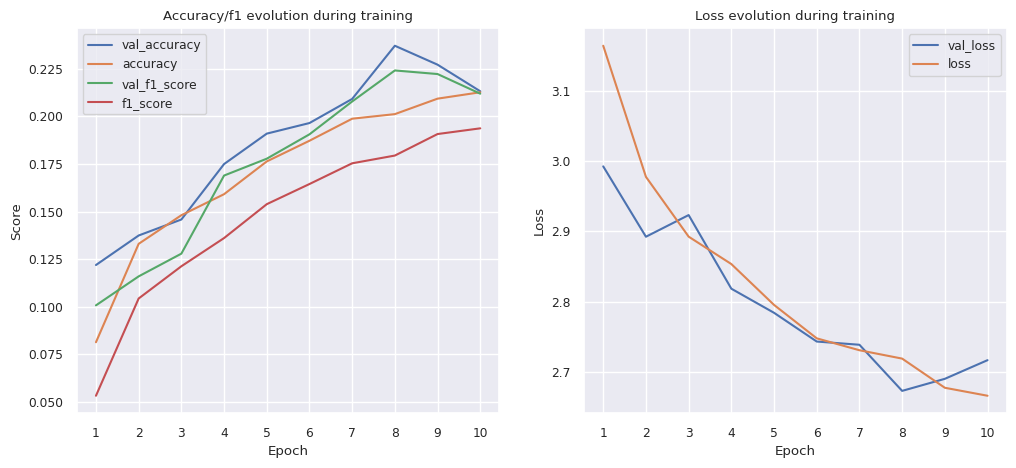

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

On note que la ralentissment de l'apprentissage observé en à l'éopque 3 de la modélisation 1.3 à diminué puisqu'il passe de 0.1 pour 3 époques à 0.1 pour 2 époques.

Le ralentissement s'accélère toujours à l'époque 7 mais moins: 0.1 pour 3 époques contre 0.1 pour 6 époques précedemment.

On observe une tendance possible à l'overfitting vers la fin puisque **val_loss** passe au dessus de **loss** qui continue de diminuer. Cela se reflète également sur l'**accuracy** et le **f1_score** de validation qui converge tous deux vers leurs courbes d'entrainement sans toute fois les croiser.

Il est possible qu'on commencer à toucher certaines limites du modèle à cause d'un dataset limité à 25% des données qui ne ne parvient pas à généraliser au delà d'un certain point.

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.29      0.18      0.22       311
        1140       0.19      0.13      0.15       267
        1160       0.35      0.78      0.48       396
        1180       0.00      0.00      0.00        76
        1280       0.13      0.02      0.03       487
        1281       0.11      0.05      0.07       207
        1300       0.26      0.26      0.26       505
        1301       0.04      0.04      0.04        81
        1302       0.12      0.09      0.10       249
        1320       0.18      0.04      0.07       324
        1560       0.19      0.07      0.11       507
        1920       0.32      0.52      0.40       431
        1940       0.07      0.27      0.11        81
        2060       0.28      0.18      0.22       499
        2220       0.02      0.04      0.02        82
        2280       0.35      0.29      0.32       476
        2403       0.32      0.28      0.30       477
        2462       0.16    

Là aussi on constate des améliorations depuis la modélisation 1.3 puisque seule la classe **1180** n'a aucune prédiction

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

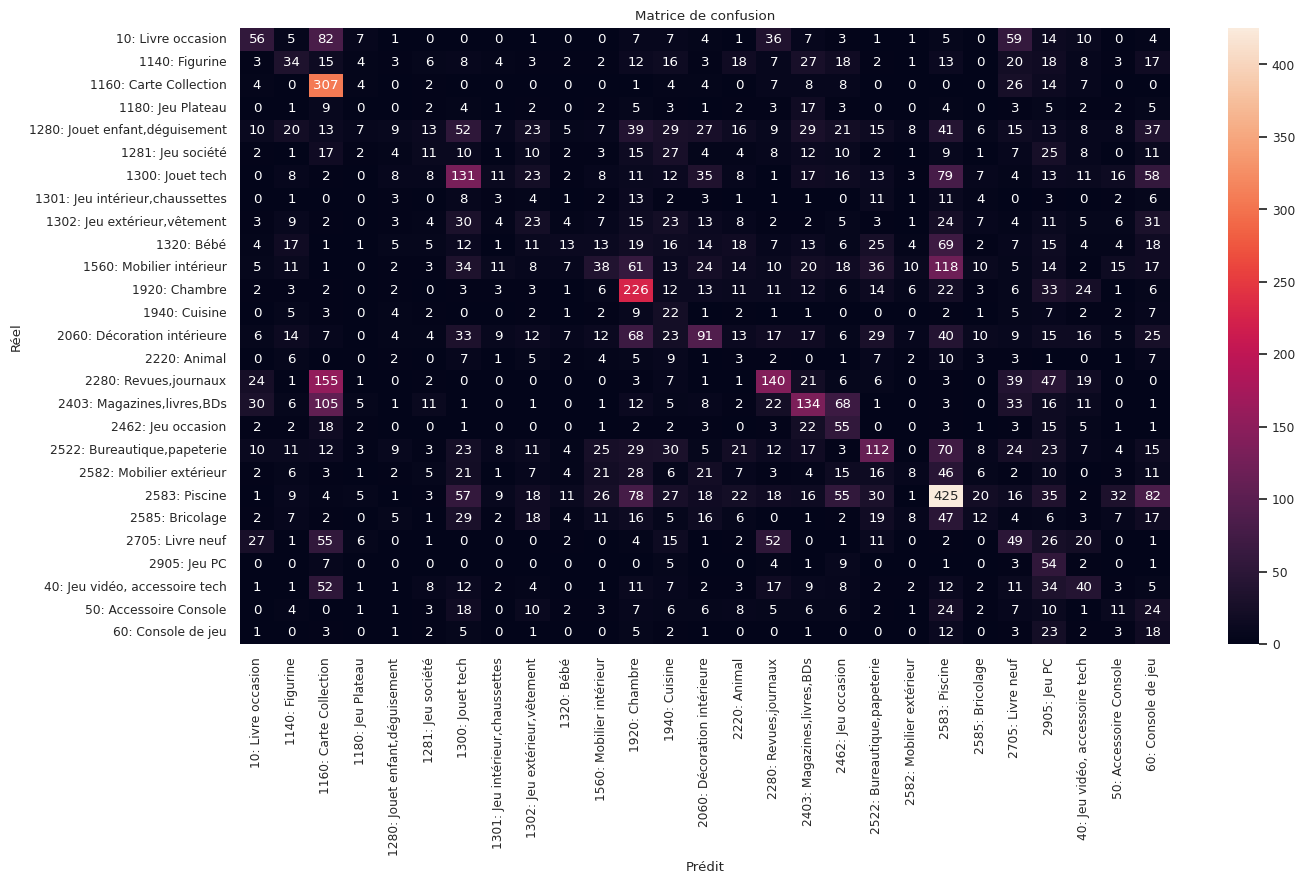

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



On constate des confusions moins fréquentes que lors de la modélisation 1.3

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.2.1
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21229.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                  0.00041
optimizer                   

# Modélisation 2.2

Intéressons-nous maintenant au paramètre **batch_size** qui régule la taille des données envoyées au modèle à chaque sous-étape d'une époque.

Tous les autres paramètres ainsi que le jeu de données seront maintenus constants afin de tenter d'isoler l'impact. Cela signifie que nous allons restaurer **start_lr** à sa valeur initiale et supprimer la stratégie __learning rate decay__.


Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 122

## Import des données

Comme nous ré-utilisons simplement le jeu de données de la modélisaton 1.3, pas besoin de ré-importer les données

## Preprocessing

On va également ré-utiliser les même jeux d'entrainement, de validation et de test

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.2.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les mêmes générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On va toutefois doubler **batch_size**. 128 pourrait être un peu élevé pour un GPU T4. Il se peut qu'on doive passer sur un A100.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 128
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-122.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                 

## Entraînement du modèle

On procède à l'entraînement du modèle de la même façon que lors de la modélisation 1.1. On veille cette fois à ne pas passer la callback **lr_scheduler** au modèle.

In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


L'augmentation du **batch_size** a permis d'accélérer l'entraînement. Sur un GPU T4, on passe de 3 minutes à 2 minutes par époque. Reste à voir quel est l'impact sur la qualité des prédictions, mais si elle ne se dégrade pas, il pourrait être intéressant de l'employer systématiquement.

On peut penser qu'on pourrait encore l'augmenter et gagner en vitesse. On sera toutefois limité à un moment par la RAM du GPU. Il pourrait être intéressant de mener des tests avec un **batch_size** plus élevé sur un GPU plus puissant comme un A100.

## Evaluation du modèle

Si un entraînement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

67/67 [==============================] - 30s 438ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fournit à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2060
accuracy on test dataset=0.2113


Le F1-score et l'accuracy sont quasi identiques à ce que nous avions avec la modélisation 1.3, reproduit ici pour référence :

```
f1_score on test dataset=0.2071
accuracy on test dataset=0.2083
```

L'accuracy a même légèrement augmenté.

On récupère l'historique d'entraînement complet grâce à **get_full_training_history** que l'on va enregistrer, puis on affiche deux graphiques :

* L'évolution de l'accuracy et du score F1 en fonction des époques.
* L'évolution des indicateurs de perte **loss** et **val_loss**.


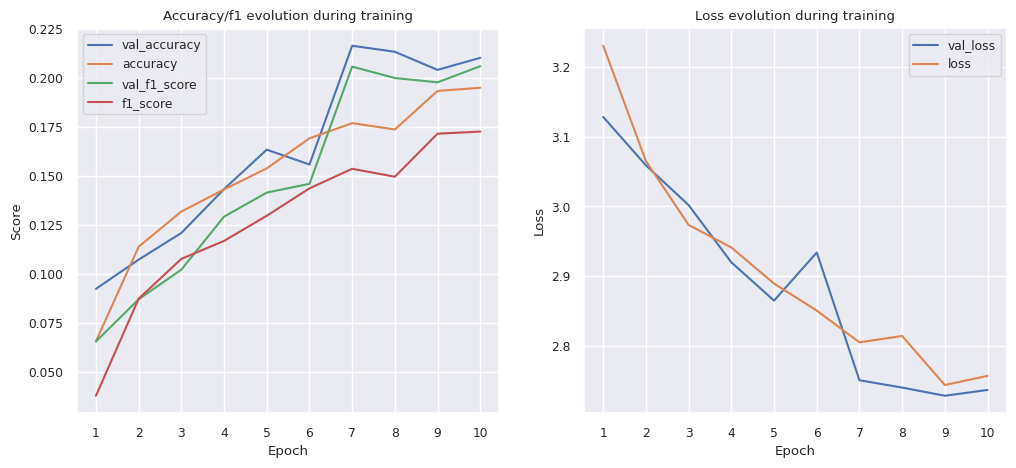

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

La **loss** s'est moins améliorée qu'avec le **batch_size** précédent. Sur les 10 époques, on observe une diminution de 0.1 (de diminution, j'entends).

L'**accuracy** et le **f1-score** suivent une tendance similaire mais finissent un peu plus haut. On note une augmentation assez nette à l'époque 6.

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.16      0.18      0.17       311
        1140       0.20      0.21      0.21       267
        1160       0.42      0.75      0.53       396
        1180       0.06      0.03      0.04        76
        1280       0.20      0.01      0.02       487
        1281       0.08      0.07      0.07       207
        1300       0.28      0.14      0.18       505
        1301       0.06      0.10      0.08        81
        1302       0.13      0.08      0.10       249
        1320       0.11      0.03      0.05       324
        1560       0.21      0.30      0.25       507
        1920       0.37      0.24      0.29       431
        1940       0.07      0.37      0.12        81
        2060       0.33      0.13      0.19       499
        2220       0.03      0.09      0.04        82
        2280       0.29      0.31      0.30       476
        2403       0.31      0.33      0.32       477
        2462       0.16    

On ne constate cette fois aucune prédiction manquante. C'est une amélioration inattendue pour moi.

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

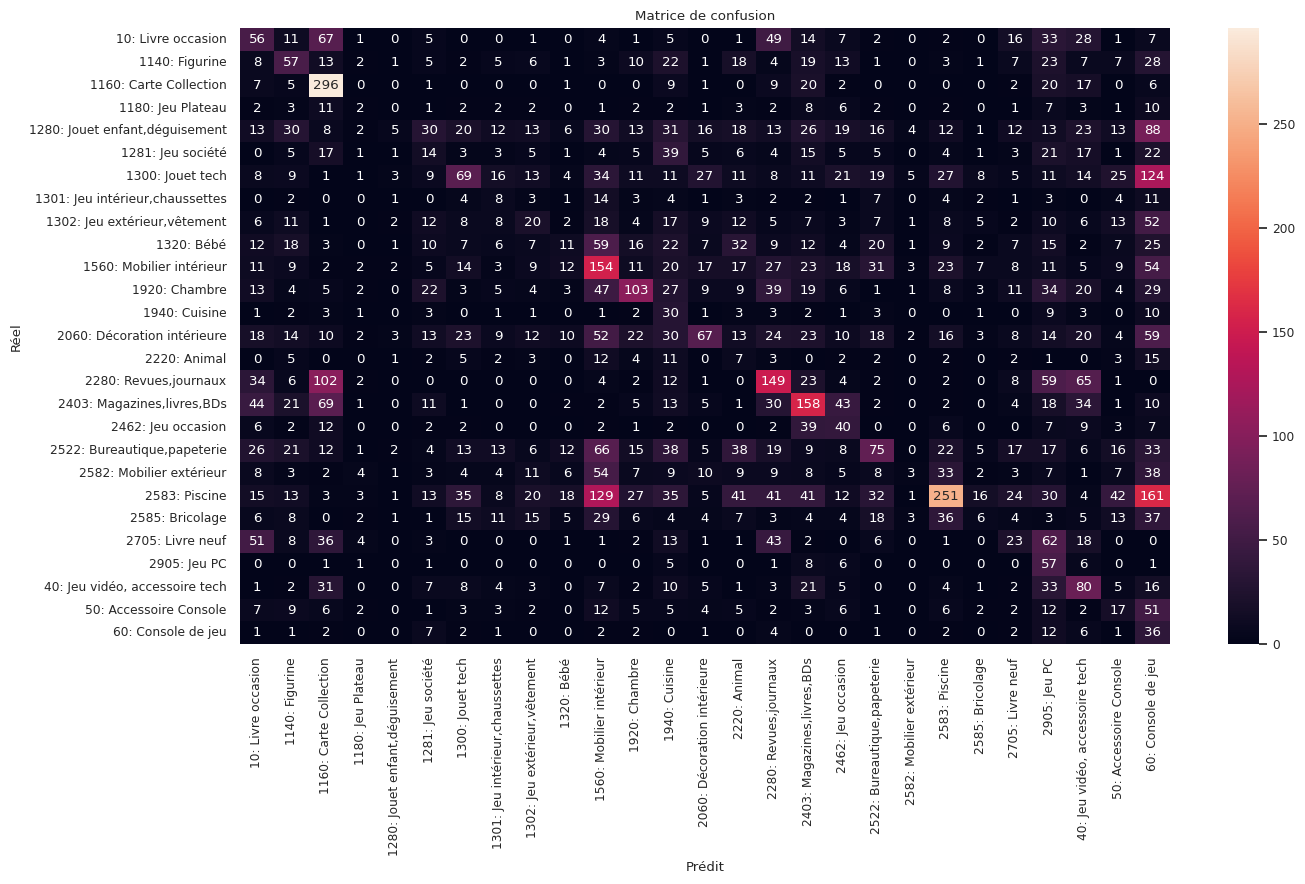

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



Les deux matrices ont un aspect assez proche. On note une diminution du nombre de prédictions correctes pour les livres d'occasion.

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.2.2
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21229.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                 128.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

Avec une qualité de prédiction égale à celle-ci, on aura tendance à privilégier un **batch_size** de 128 plutôt que de 64 pour accélérer l'entraînement.


# Modélisation 2.3

Intéressons-nous maintenant à la taille des images. Voyons comment le modèle réagit lorsque nous augmentons celle-ci.

Tous les autres paramètres ainsi que le jeu de données seront maintenus constants afin de tenter d'isoler l'impact. Cela signifie que nous allons restaurer **batch_size** à sa valeur initiale.

Changeons la variable **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 123

## Import des données

Comme nous réutilisons simplement le jeu de données de la modélisation 1.3, pas besoin de ré-importer les données.


## Preprocessing

On va également réutiliser les mêmes jeux d'entraînement, de validation et de test.

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.2.3")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les mêmes générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense à restaurer **batch_size** à sa valeur initiale et à doubler **target_image_size**.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.


In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 64
target_img_size = (256,256,3)
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21229 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-123.keras
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d_4 (Avera  (None, 126, 126, 6)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 61, 61, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 59536)             0         
                                                 

## Entraînement du modèle

On procéde à l'entraînement du modèle de la même façon que lors de la modélisation 1.1.



In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


Le doublement de la taille des images a un impact considérable sur la durée d'entraînement. On passe de 3 à 6 minutes par époque. Pour l'instant, on a choisi de ne varier qu'un paramètre à la fois, mais pour bien faire, il faudrait également doubler **batch_size** pour tenter de compenser la diminution de la vitesse d'entraînement.


## Evaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, on recharge le meilleur modèle qu'on a trouvé.


In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 51s 384ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on l'a fournie à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2403
accuracy on test dataset=0.2401


L'augmentation de la taille des images nous fait gagner 4%. C'est encourageant, il serait tentant de pousser si notre architecture actuelle, LeNet, le supporte.


On récupère l'historique d'entraînement complet grâce à **get_full_training_history** que l'on va enregistrer, puis on affiche deux graphiques :

- L'évolution de l'accuracy et du score F1 en fonction des époques.
- L'évolution des indicateurs de perte **loss** et **val_loss**.


In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

_À cause d'un bug technique, nous n'avons malheureusement pas pu enregistrer l'historique d'entraînement._

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.24      0.22      0.23       311
        1140       0.18      0.22      0.20       267
        1160       0.52      0.67      0.58       396
        1180       0.05      0.09      0.06        76
        1280       0.19      0.11      0.14       487
        1281       0.15      0.06      0.09       207
        1300       0.28      0.25      0.27       505
        1301       0.03      0.06      0.04        81
        1302       0.10      0.03      0.05       249
        1320       0.13      0.06      0.08       324
        1560       0.24      0.20      0.22       507
        1920       0.43      0.39      0.41       431
        1940       0.07      0.26      0.11        81
        2060       0.30      0.22      0.26       499
        2220       0.04      0.07      0.05        82
        2280       0.54      0.18      0.27       476
        2403       0.38      0.34      0.36       477
        2462       0.18    

On ne constate aucune classe avec zéro prédictions, de plus certaines classes commencent à avoir un score qui se rapproche de l'intervalle [0.5, 0.6] qu'on aimerait atteindre, comme par exemple la classe **1920** _chambre_ avec 0.41.

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

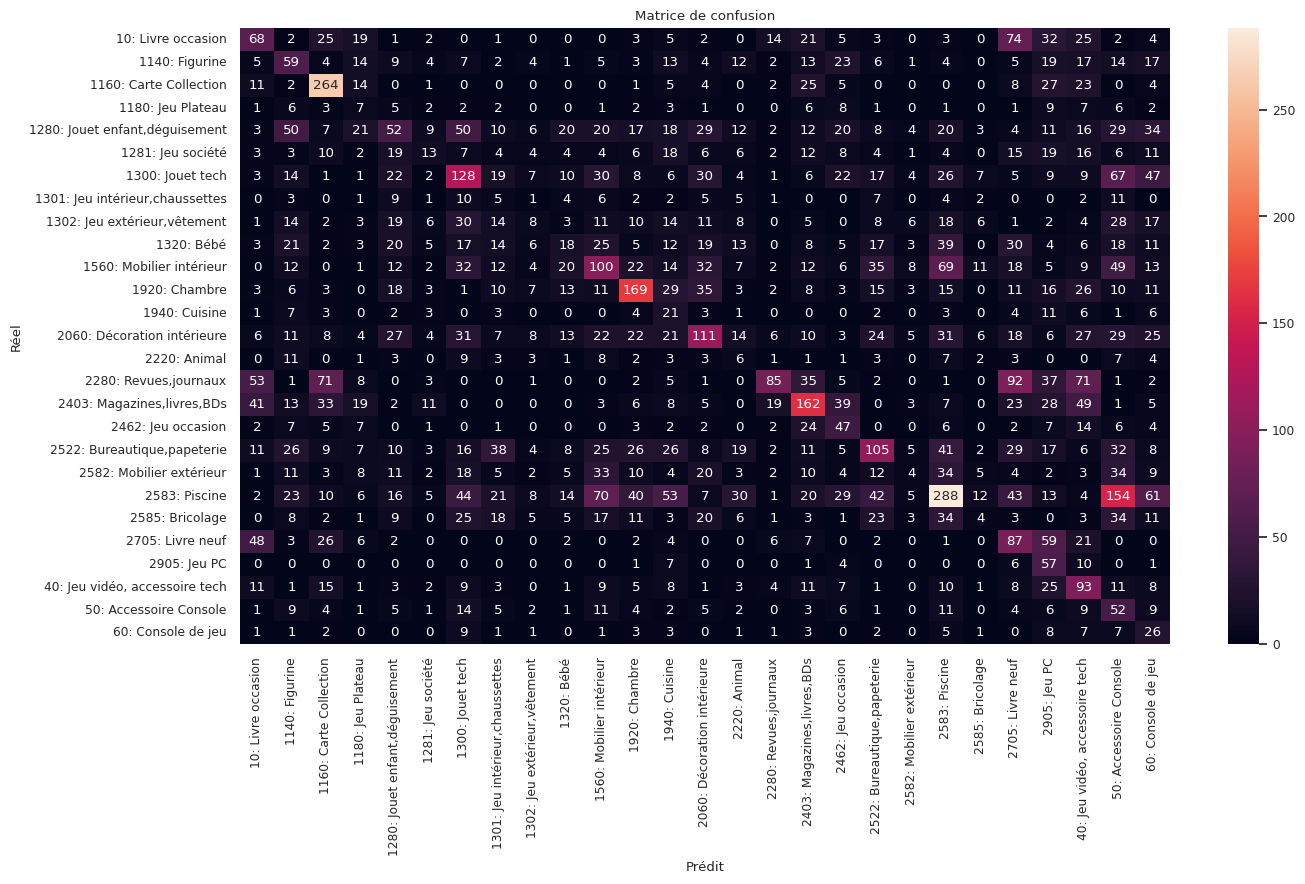

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



On remarque un renforcement de la diagonale des vrais positifs par rapport à la modélisation 1.3. On note aussi une diminution globale du nombre de faux positifs, en particulier pour la classe **60**.


## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.2.3
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21229.0
image_size                                                                 256.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Comparaisons des modélisations de la stratégie 2

On va maintenant pouvoir comparer les rapports des 3 modélisations de cette deuxième section. Affichons leur rapport côte à côte

In [ ]:
display(reporting_df.loc[[121,122,123],model_comparison_cols].T)

model_id,121,122,123
model_name,Modèle 1.2.1,Modèle 1.2.2,Modèle 1.2.3
dataset_resampled,True,True,True
image_dataset_zoomed,True,True,True
train_size,21229.0,21229.0,21229.0
image_size,128.0,128.0,256.0
batch_size,64.0,128.0,64.0
test_f1_score,0.221112,0.20597,0.240261
test_accuracy,0.23846,0.211258,0.240108
loss,2.718754,2.756888,2.771065
val_loss,2.672804,2.736719,2.760436


Au vu de nos analyses, les paramètres les plus prometteurs semblent être:

- Utiliser un _decay learning rate_, qu'on devra probablement ajuster encore si on change d'autres paramètres.
- Utiliser un **batch_size** d'au moins 128.
- Utiliser au moins une **image_size** de 256.


# Modélisation 3.1

Nous avons maintenant une meilleure idée de quels sont les meilleurs jeux de données et hyperparamètres. Nous allons mettre à profit nos expérimentations et essayer d'en tirer le meilleur parti afin de concevoir un modèle qui soit le plus performant possible, tout en conservant l'architecture CNN que nous avons utilisée tout au long de ce notebook.

Nous pouvons partir sur ces paramètres pour notre modèle :
- Dataset d'images zoomées
- Dataset rééquilibré
- **batch_size** = 128
- **image_size** = 256
- **learning_rate_decay** avec des paramètres à déterminer

Commençons par lancer un premier test de modélisation sur 10 époques pour tenter de déterminer les paramètres adéquats de **learning_rate_decay** pour cette nouvelle configuration. Nous allons quelque peu augmenter les données et passer à 30 % du jeu de données augmenté cette fois-ci. Cela représente environ 33 000 observations, contre 21 000 auparavant, et devrait nous donner des indications plus représentatives.


Changeons la variable **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 131

## Import des données

Comme nous réutilisons simplement les mêmes sources de données que la modélisation 1.3, pas besoin de les réimporter.


## Preprocessing

On sépare les variables explicatives de la cible.

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On applique un traitement similaire à la modélisation 1.3 mais en modifiant **target_train_size**.


In [ ]:
target_train_size = int(len(X_train)*0.3)
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 32869
X_train length is now 32869


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1320    1218
2522    1218
1302    1218
1300    1218
2220    1218
1560    1218
1281    1218
2060    1218
10      1218
2585    1218
2280    1217
40      1217
1180    1217
1301    1217
2705    1217
1140    1217
1920    1217
2462    1217
60      1217
1160    1217
1280    1217
2905    1217
50      1217
2583    1217
1940    1217
2582    1217
2403    1217
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibrés à 10% des données

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.3.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On conserve les transformations d'images inchangées pour le moment.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.


In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 128 #todo: adjust
target_img_size = (256,256,3) #todo: adjust
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 32869 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  #todo: ajust start learning rate, and add a learning rate scheduler ?
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-131.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 126, 126, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 61, 61, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                   

## Entraînement du modèle

On procéde à l'entraînement du modèle de la même façon que lors de la modélisation 1.1.



In [ ]:
if not get_reporting_value(model_id,"fit_complete",False):

  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


Avec l'augmentation du nombre de données et de la taille des images, l'entraînement a mis plus d'une heure

## Evaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, on recharge le meilleur modèle qu'on a trouvé.

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

67/67 [==============================] - 42s 628ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.2706
accuracy on test dataset=0.2801


On obtient un f1-score de 0.27. C'est le score le plus élevé qu'on ait obtenu jusque alors.

On récupère l'historique d'entraînement complet grâce à **get_full_training_history** qu'on va enregistrer, puis on affiche deux graphiques :
* L'évolution de l'accuracy et du score f1 en fonction des époques.
* L'évolution des indicateurs de perte **loss** et **val_loss**.


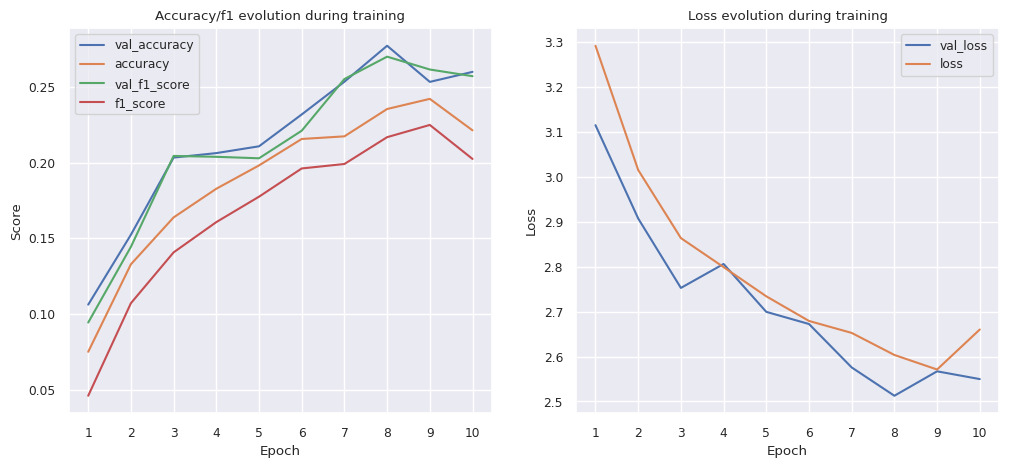

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

On constate que **val_accuracy** et **val_f1_score** se maintiennent toujours au-dessus de leurs homonymes d'entraînement, ce qui laisse entendre que le modèle a encore un potentiel d'amélioration avec plus d'entraînement.

Côté **loss**, elle décroît bien, sauf à la dernière époque. La courbe s'aplatit au fil des époques. Si on analyse la variation de la pente, on obtient :
* Époques [1,2] : -0.3
* Époques [2,4] : -0.2/2 = -0.1
* Époques [4,8] : -0.2/4 = -0.05
* Époques [8,10] : 0.25/2 = 0.0125

On veillera à ajuster les paramètres de **learning_rate_decay** pour tenter de compenser ce ralentissement.


On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.27      0.18      0.22       311
        1140       0.23      0.21      0.22       267
        1160       0.53      0.74      0.61       396
        1180       0.06      0.05      0.06        76
        1280       0.21      0.01      0.03       487
        1281       0.13      0.07      0.09       207
        1300       0.41      0.15      0.22       505
        1301       0.06      0.04      0.05        81
        1302       0.14      0.16      0.15       249
        1320       0.18      0.11      0.13       324
        1560       0.24      0.28      0.26       507
        1920       0.36      0.52      0.43       431
        1940       0.08      0.25      0.12        81
        2060       0.32      0.16      0.22       499
        2220       0.04      0.09      0.05        82
        2280       0.51      0.37      0.43       476
        2403       0.34      0.43      0.38       477
        2462       0.22    

On obtient un f1-score de 0.61 pour la classe **1160**. C'est le score le plus élevé qu'on ait eu jusqu'à présent.

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

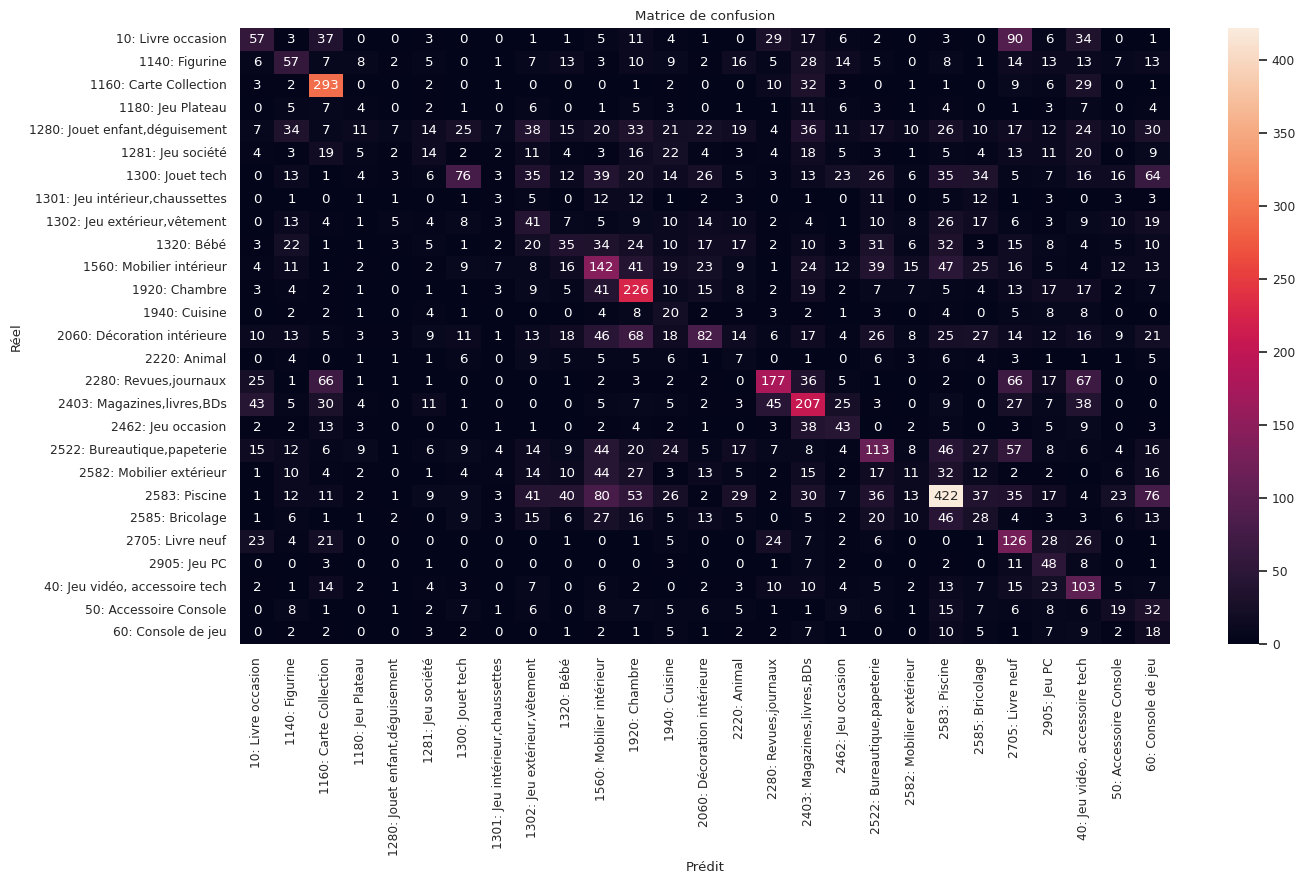

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



La diagonale de vrais positifs est plus visible que lors des tests précédents grâce à la diminution du bruit de fond des confusions.

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.3.1
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               32869.0
image_size                                                                 256.0
image_color_rgb                                                             True
batch_size                                                                 128.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

Ce premier test de modélisation ajusté à partir des conclusions tirées des sections précédentes nous conforte dans la justesse des choix qui ont été faits. Il nous a aussi permis d'obtenir des informations sur les ajustements possibles à apporter au learning rate.


# Modélisation 3.2

On a pu observer l'évolution de **loss** dans notre modélisation précédente. On va maintenant pouvoir lancer le véritable entraînement. Cette fois-ci, on va:

- Utiliser le dataset complet
- Augmenter le nombre d'époques à 10
- Passer à un **learning_rate_decay** qu'on va ajuster par rapport à nos observations de la modélisation 3.1 et à l'augmentation du nombre d'époques.


Changeons la variable **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 132

## Import des données

Comme nous ré-utilisons simplement les mêmes sources de données que la modélisaton 3.1, pas besoin de les ré-importer.


## Preprocessing

On sépare les variables explicatives de la cible.

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

Confirmons que les classes sont bien équilibrées

In [ ]:
y_train.value_counts()

10      4058
1920    4058
2705    4058
2585    4058
2583    4058
2582    4058
2522    4058
2462    4058
2403    4058
2280    4058
2220    4058
2060    4058
1940    4058
1560    4058
40      4058
1320    4058
1302    4058
1301    4058
1300    4058
1281    4058
1280    4058
1180    4058
1160    4058
1140    4058
60      4058
50      4058
2905    4058
Name: prdtypecode, dtype: int64

C'est bien le cas

Comme on utilise cette fois la totalité des données, pas besoin d'autres préparations.

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.232326,0.243619,0.237610,0.279707,0.293679,0.290391,2.482575,2.452756,NaN
112,Modèle 1.1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223169,0.244186,0.242837,0.270399,0.289536,0.295337,2.500585,2.452618,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.180149,0.206703,0.207138,0.201984,0.207860,0.208314,2.707499,2.748649,NaN
121,Modèle 1.2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21229.0,128.0,True,64.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.179420,0.224122,0.221112,0.201181,0.237098,0.238460,2.718754,2.672804,use learning_rate_decay with decay_factor=0.8 ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.3.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On conserve les transformations d'images inchangées pour le moment

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 128 #todo: adjust
target_img_size = (256,256,3) #todo: adjust
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 109566 validated image filenames belonging to 27 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [ ]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  #todo: ajust start learning rate, and add a learning rate scheduler ?
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-132.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 126, 126, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 61, 61, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                   

## Entraînement du modèle

Créons une callback qui nous permettra d'implémenter notre stratégie de _Learning rate decay_. Si l'on revient sur les graphiques de **loss** de la modélisation 3.1, on observe que le ralentissement de la diminution de **loss** intervient dès l'époque 2. On choisit donc un **decay_step** relativement bas pour assurer un ajustement qui commence rapidement mais pas trop non plus, afin de prendre en compte les 20 époques de notre entraînement.

On augmente légèrement aussi **decay_factor** pour permettre une modification plus progressive du **lr** sur les 20 époques.

On laisse le **start_lr** inchangé car un test __off-screen__ d'un **start_lr** multiplié par 10 révèle que cela ne fonctionne pas bien.


In [ ]:
def learning_rate_decay(epoch, lr):
    initial_lr = start_lr
    decay_factor = 0.9 # 0.2 in model 2.1
    decay_step = 3  #2 in model 2.1

    new_lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return new_lr

lr_scheduler = LearningRateScheduler(learning_rate_decay, verbose=1)

update_reporting_line(model_id,{
      "start_lr": start_lr,
      "remarks": "use learning_rate_decay with decay_factor=0.9 and decay_step=3"
})

Procédons à l'entraînement du modèle. Là encore, nous réutilisons les paramètres initiaux, à l'exception du fait que nous passons notre callback **lr_scheduler** au modèle.


In [ ]:
target_epochs=20

if not get_reporting_value(model_id,"fit_complete",False):

  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),lr_scheduler,early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


L'entraînement aura duré prés de 12 heures !

## Evaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, nous rechargeons le meilleur modèle que nous avons trouvé.


In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

67/67 [==============================] - 41s 613ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait, pour chaque observation, l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on l'a fournie à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.3080
accuracy on test dataset=0.3069


On obtient un f1-score de 0.31. On aurait pu espérer mieux sur 20 époques, mais cela reste tout de même le score le plus élevé que nous ayons atteint jusqu'à présent.


On récupère l'historique d'entraînement complet grâce à **get_full_training_history** que l'on va enregistrer, puis on affiche deux graphiques :

- L'évolution de l'accuracy et du score f1 en fonction des époques
- L'évolution des indicateurs de perte **loss** et **val_loss**


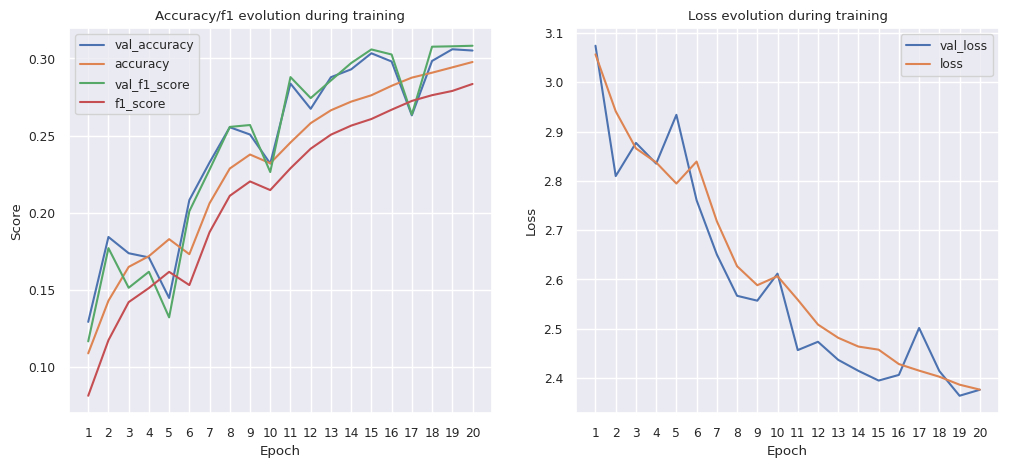

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

Les courbes de **val_accuracy** et de **val_f1_score** sont plus crénelées dans cette version. On constate des allers-retours périodiques sous leurs équivalents d'entraînement. Elles se maintiennent malgré tout majoritairement au-dessus. Le graphique laisse penser qu'on pourrait poursuivre l'entraînement et encore progresser malgré un ralentissement vers la fin.

La courbe de perte a cette fois une pente quasi constante jusqu'à l'époque 10 malgré quelques bosses. Il semble que la stratégie de **learning_rate_decay** a bien fonctionné. Au-delà de l'époque 10, elle devient plus lisse et ralentit à nouveau progressivement. Une nouvelle approche pour accélérer l'entraînement pourrait être intéressante. Elle n'atteint pas de plateau visible, mais on peut se demander si elle ne se dirige pas vers un minimum local. Il faudrait pouvoir multiplier les époques pour le savoir.

Les bosses nous montrent que plusieurs minimums locaux ont été franchis avec succès.

La **val_loss** passe plusieurs fois au-dessus de la **loss** après les diminutions les plus fortes de cette dernière : après un rapide apprentissage, le modèle devient temporairement plus fort sur les données d'entraînement (overfitting) plus l'équilibre se rétablit. Si on parvenait à accélérer la vitesse d'entraînement, il faudrait sans doute augmenter aussi celle de généralisation en haussant les paramètres de transformations d'images, par exemple.


On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.28      0.39      0.32       311
        1140       0.34      0.22      0.27       267
        1160       0.73      0.65      0.69       396
        1180       0.09      0.21      0.13        76
        1280       0.25      0.08      0.12       487
        1281       0.15      0.08      0.11       207
        1300       0.38      0.28      0.32       505
        1301       0.11      0.28      0.16        81
        1302       0.08      0.04      0.05       249
        1320       0.26      0.19      0.22       324
        1560       0.31      0.28      0.29       507
        1920       0.34      0.56      0.42       431
        1940       0.12      0.53      0.19        81
        2060       0.28      0.14      0.19       499
        2220       0.05      0.12      0.07        82
        2280       0.51      0.47      0.49       476
        2403       0.37      0.37      0.37       477
        2462       0.24    

La classe **1160** progresse encore pour atteindre un nouveau maximum de 0.69. Plusieurs autres classes se rapprochent d'un seuil respectable de 0.5.


Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

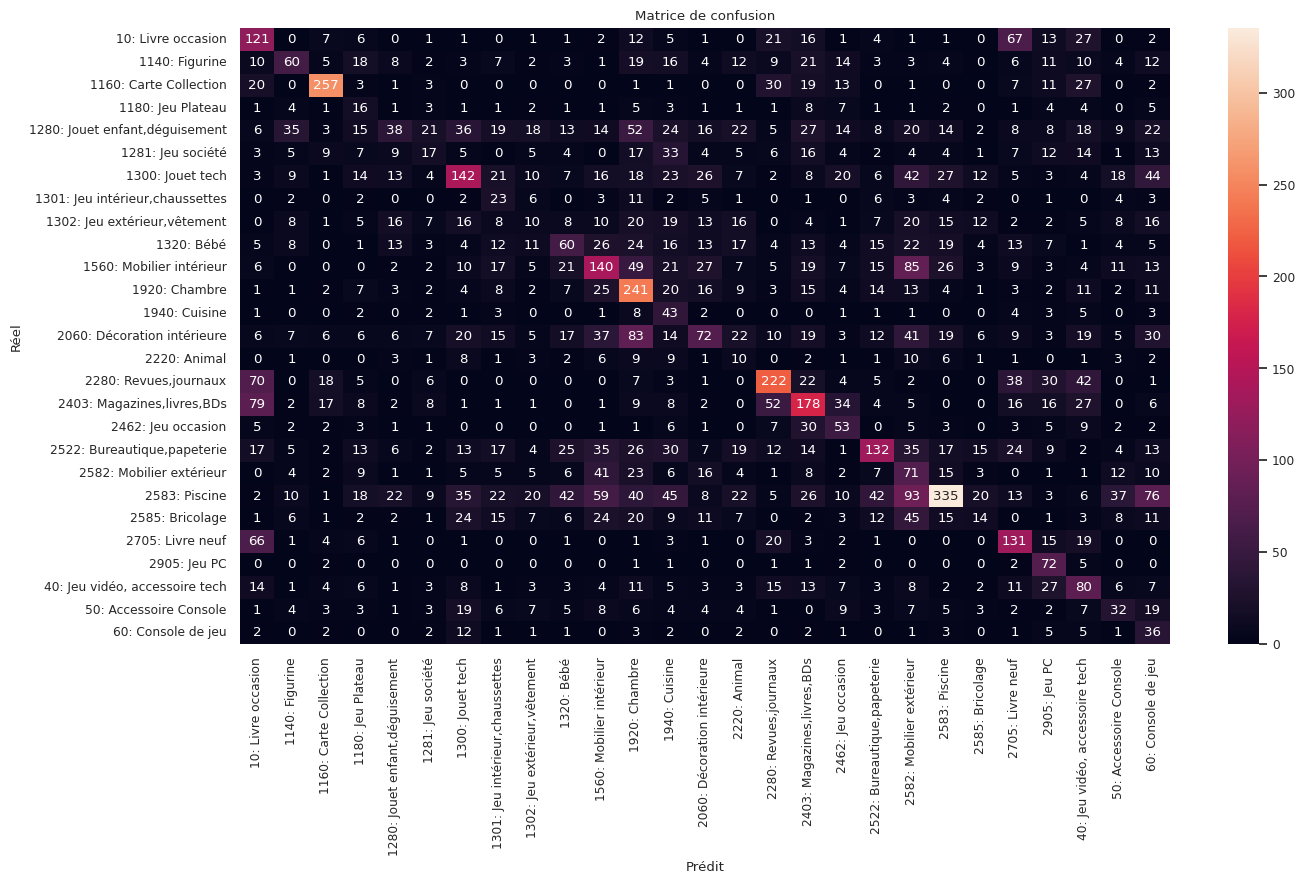

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



La diagonale des vrais positifs se distingue plus nettement que jamais.

On constate l'apparition de faux positifs logiques ce qui laisse entendre que notre modèle commence à percevoir les charactéristiques pertinentes des images. La classe 10 _"livre occasion"_ par exemple a des faux positifs avec:
* _"livre neuf"_
* _"Magazines, livres, BDs"_
* _"Revues, journaux"_

La diagonale des vrais positifs se distingue plus nettement que jamais.

On constate l'apparition de faux positifs logiques, ce qui laisse entendre que notre modèle commence à percevoir les caractéristiques pertinentes des images. La classe 10 _"livre occasion"_, par exemple, a des faux positifs avec :
- _"livre neuf"_
- _"Magazines, livres, BDs"_
- _"Revues, journaux"_


## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.3.2
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                              109566.0
image_size                                                                 256.0
image_color_rgb                                                             True
batch_size                                                                 128.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                 0.000531
optimizer                   

# Comparaison de tous les modèles du notebook

Comparons maintenant tous les modèles du notebook.

In [ ]:
display(reporting_df.loc[[111,112,113,121,122,123,131,132],model_comparison_cols].T)

model_id,111,112,113,121,122,123,131,132
model_name,Modèle 1.1.1,Modèle 1.1.2,Modèle 1.1.3,Modèle 1.2.1,Modèle 1.2.2,Modèle 1.2.3,Modèle 1.3.1,Modèle 1.3.2
dataset_resampled,False,False,True,True,True,True,True,True
image_dataset_zoomed,False,True,True,True,True,True,True,True
train_size,21229.0,21229.0,21229.0,21229.0,21229.0,21229.0,32869.0,109566.0
image_size,128.0,128.0,128.0,128.0,128.0,256.0,256.0,256.0
batch_size,64.0,64.0,64.0,64.0,128.0,64.0,128.0,128.0
test_f1_score,0.23761,0.242837,0.207138,0.221112,0.20597,0.240261,0.270583,0.307977
test_accuracy,0.290391,0.295337,0.208314,0.23846,0.211258,0.240108,0.280146,0.306877
loss,2.482575,2.500585,2.707499,2.718754,2.756888,2.771065,2.603446,2.3765
val_loss,2.452756,2.452618,2.748649,2.672804,2.736719,2.760436,2.512697,2.376215


# Conclusion

Ce notebook nous a permis de tester l'impact de différents pré-traitements (rééquilibrage des classes, zoom des images) sur la performance d'un modèle CNN classique comme Lenet. On a aussi pu tester et mieux comprendre l'influence de différents hyper-paramètres comme le learning rate, la taille des batch et la taille des images.

Les performances obtenues avec le dernier modèle sont encore loin des 0.5-0.6 qu'on aimerait atteindre. Il est probable qu'entraîner encore le modèle améliorerait les performances, même si on ignore jusqu'à quel point. Notre temps et nos ressources de calcul étant limités, il est difficile de pousser plus loin l'expérience avec ce modèle Lenet.

Dans les prochains notebooks, nous explorerons des CNN de transfer learning qui nous permettront, on l'espère, d'obtenir de meilleures performances dans un temps raisonnable.